# A Convolutional Autoencoder for Anomaly Detection

Anomaly detection is the task of finding anomalous data elements in a dataset. An anomaly is a data element that is an outlier with respect to the rest of the dataset.

We are going to train an autoencoder on the MNIST dataset (that only contains numbers), and then we will look into anomalies within the MNIST dataset (i.e., images within MNIST that are somehow different than the rest of the dataset).

Even though MNIST is a labeled dataset, we are going to disregard the labels for educational purposes and consider it as an unlabeled datcoder.**

In [1]:
!pip install -r requirements.txt | grep -v "already"

In [2]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True) # Restart automatically

{'status': 'ok', 'restart': True}

In [1]:
import torch
from torch import nn

import torchvision.models
import torchvision.transforms as T
from torchvision import datasets

import numpy as np
import pandas as pd
import multiprocessing
from tqdm import tqdm

from helpers import (get_data_loaders, seed_all, anomaly_detection_display)

seed_all(42)

In [2]:
data_loaders = get_data_loaders(batch_size=1024)

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


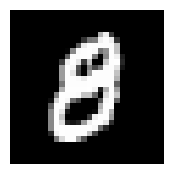

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(data_loaders['train'])
images, labels = next(dataiter)
images = images.numpy()

img = np.squeeze(images[0])

fig, sub = plt.subplots(figsize=(2, 2))
sub.imshow(img, cmap='gray')
_ = sub.axis('off')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Convolutional AutoEncoder Architecture

In [5]:
class AutoEncoder(nn.Module):

    def __init__(self):
        super(AutoEncoder, self).__init__()

        ## Encoder ##
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), # output feature map dim = input dim
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2)
        ) # -> 32 x 8 x 8

        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d()
            nn.Upsample(scale_factor=2, mode='nearest'), # k-nearest neighbor linear upsampling,
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.Upsample(scale_factor=2, mode='nearest'), # k-nearest neighbor linear upsampling,
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid() # ensure the output values are within the range [0, 1]
        )

        self.autoencoder = nn.Sequential(
            self.encoder,
            self.decoder
        )

    def forward(self, x):
        # define feed-forward behaviour

        return self.autoencoder(x)

model = AutoEncoder()
model.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode='nearest')
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Upsample(scale_factor=2.0, mode='nearest')
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(32, eps=1e

In [6]:
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 32, 28, 28]             320
              ReLU-3           [-1, 32, 28, 28]               0
              ReLU-4           [-1, 32, 28, 28]               0
       BatchNorm2d-5           [-1, 32, 28, 28]              64
       BatchNorm2d-6           [-1, 32, 28, 28]              64
         MaxPool2d-7           [-1, 32, 14, 14]               0
         MaxPool2d-8           [-1, 32, 14, 14]               0
            Conv2d-9           [-1, 32, 14, 14]           9,248
           Conv2d-10           [-1, 32, 14, 14]           9,248
             ReLU-11           [-1, 32, 14, 14]               0
             ReLU-12           [-1, 32, 14, 14]               0
      BatchNorm2d-13           [-1, 32, 14, 14]              64
      BatchNorm2d-14           [-1, 32,

---
### Loss Function
We will use se the Mean Squared Error loss, which is called `MSELoss` in PyTorch:

In [7]:
criterion = nn.MSELoss()

### Optimizer

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

### Training

The training loop is similar to a normal training loop, however, this task is an unsupervised task. That means we do not need labels. The MNIST dataset does provide labels, of course, so we will just disregard them.

In [9]:
n_epochs = 50

for epoch in range(1, n_epochs + 1):
    # set to training mode
    model.train()

    train_loss = 0.0

    for data in tqdm(
        iterable=data_loaders["train"],
        desc="Training",
        total=len(data_loaders["train"]),
        ncols=80,
    ):
        # Disregard labels
        images, _ = data
        images = images.to(device)

        # Clear the gradients of all optimizer variables
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate the loss (between input and output)
        loss = criterion(outputs.flatten(), images.flatten())

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # perform a single optimization step
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    # validation
    val_loss = 0.0

    with torch.no_grad():
        for data in tqdm(
            iterable=data_loaders["val"],
            desc="Validating",
            total=len(data_loaders["val"]),
            ncols=80,
        ):
            # Disregard labels
            images, _ = data
            images = images.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate the loss (between input and output)
            loss = criterion(outputs.flatten(), images.flatten())

            val_loss += loss.item() * images.size(0)

    # Print avg training statistics
    train_loss /= len(data_loaders["train"])
    val_loss /= len(data_loaders["val"])

    print(
        "Epoch: {} \tTraining Loss: {:.6f}\tValid Loss: {:.6f}".format(
            epoch, train_loss, val_loss
        )
    )


Validating: 100%|███████████████████████████████| 12/12 [00:12<00:00,  1.02s/it]


Epoch: 1 	Training Loss: 63.592402	Valid Loss: 27.160117


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.10it/s]


Epoch: 2 	Training Loss: 19.185352	Valid Loss: 14.143506


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.10it/s]


Epoch: 3 	Training Loss: 9.419920	Valid Loss: 7.282149


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.15it/s]


Epoch: 4 	Training Loss: 6.403845	Valid Loss: 5.298812


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.06it/s]


Epoch: 5 	Training Loss: 5.597542	Valid Loss: 4.950186


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.04it/s]


Epoch: 6 	Training Loss: 4.551082	Valid Loss: 4.133545


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.13it/s]


Epoch: 7 	Training Loss: 4.220547	Valid Loss: 4.131703


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.05it/s]


Epoch: 8 	Training Loss: 3.960644	Valid Loss: 3.639312


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.07it/s]


Epoch: 9 	Training Loss: 3.684543	Valid Loss: 4.244918


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.13it/s]


Epoch: 10 	Training Loss: 3.610922	Valid Loss: 3.281291


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.02it/s]


Epoch: 11 	Training Loss: 3.615966	Valid Loss: 3.276268


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.07it/s]


Epoch: 12 	Training Loss: 3.231140	Valid Loss: 3.095709


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.01it/s]


Epoch: 13 	Training Loss: 3.105252	Valid Loss: 2.937039


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.01it/s]


Epoch: 14 	Training Loss: 2.976280	Valid Loss: 2.922499


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.12it/s]


Epoch: 15 	Training Loss: 3.008565	Valid Loss: 2.711544


Validating: 100%|███████████████████████████████| 12/12 [00:13<00:00,  1.17s/it]


Epoch: 16 	Training Loss: 2.802779	Valid Loss: 2.641768


Validating: 100%|███████████████████████████████| 12/12 [00:09<00:00,  1.21it/s]


Epoch: 17 	Training Loss: 2.688558	Valid Loss: 2.600838


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.01it/s]


Epoch: 18 	Training Loss: 2.625014	Valid Loss: 2.449890


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.10it/s]


Epoch: 19 	Training Loss: 2.497711	Valid Loss: 2.434129


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.03it/s]


Epoch: 20 	Training Loss: 2.439004	Valid Loss: 2.332262


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.12it/s]


Epoch: 21 	Training Loss: 2.491348	Valid Loss: 2.545640


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.12it/s]


Epoch: 22 	Training Loss: 2.369298	Valid Loss: 2.213945


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.05it/s]


Epoch: 23 	Training Loss: 2.306938	Valid Loss: 2.250197


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.13it/s]


Epoch: 24 	Training Loss: 2.230185	Valid Loss: 2.195088


Validating: 100%|███████████████████████████████| 12/12 [00:14<00:00,  1.19s/it]


Epoch: 25 	Training Loss: 2.187979	Valid Loss: 2.093873


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.00it/s]


Epoch: 26 	Training Loss: 2.198862	Valid Loss: 2.194332


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.07it/s]


Epoch: 27 	Training Loss: 2.109955	Valid Loss: 2.009934


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.12it/s]


Epoch: 28 	Training Loss: 2.112032	Valid Loss: 2.080708


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.04it/s]


Epoch: 29 	Training Loss: 2.064321	Valid Loss: 1.958424


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.10it/s]


Epoch: 30 	Training Loss: 2.068209	Valid Loss: 2.063691


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.09it/s]


Epoch: 31 	Training Loss: 2.038803	Valid Loss: 1.986364


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.06it/s]


Epoch: 32 	Training Loss: 2.102888	Valid Loss: 1.946891


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.01it/s]


Epoch: 33 	Training Loss: 1.958828	Valid Loss: 1.903928


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.01it/s]


Epoch: 34 	Training Loss: 1.904665	Valid Loss: 1.809637


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.12it/s]


Epoch: 35 	Training Loss: 1.869226	Valid Loss: 1.811910


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.03it/s]


Epoch: 36 	Training Loss: 1.896260	Valid Loss: 2.022594


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.10it/s]


Epoch: 37 	Training Loss: 1.838618	Valid Loss: 1.768325


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.08it/s]


Epoch: 38 	Training Loss: 1.807250	Valid Loss: 1.737067


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.09it/s]


Epoch: 39 	Training Loss: 1.780672	Valid Loss: 1.802725


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.09it/s]


Epoch: 40 	Training Loss: 1.778693	Valid Loss: 1.683483


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.09it/s]


Epoch: 41 	Training Loss: 1.760539	Valid Loss: 1.752654


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.01it/s]


Epoch: 42 	Training Loss: 1.704268	Valid Loss: 1.729622


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.15it/s]


Epoch: 43 	Training Loss: 1.738766	Valid Loss: 1.679872


Validating: 100%|███████████████████████████████| 12/12 [00:13<00:00,  1.09s/it]


Epoch: 44 	Training Loss: 1.755990	Valid Loss: 1.724312


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.14it/s]


Epoch: 45 	Training Loss: 1.708050	Valid Loss: 1.610125


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.03it/s]


Epoch: 46 	Training Loss: 1.679792	Valid Loss: 1.729707


Validating: 100%|███████████████████████████████| 12/12 [00:11<00:00,  1.09it/s]


Epoch: 47 	Training Loss: 1.678202	Valid Loss: 1.694716


Validating: 100%|███████████████████████████████| 12/12 [00:12<00:00,  1.02s/it]


Epoch: 48 	Training Loss: 1.621588	Valid Loss: 1.615382


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.14it/s]


Epoch: 49 	Training Loss: 1.608987	Valid Loss: 1.653938


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.10it/s]

Epoch: 50 	Training Loss: 1.600751	Valid Loss: 1.563998


## Testing and Finding Anomalies
Now that our autoencoder is trained we can use it to find anomalies. Let's consider the test set. We loop over all the batches in the test set and we record the value of the loss for each example separately. The examples with the highest reconstruction loss are our anomalies. 

Indeed, if the reconstruction loss is high, that means that our trained autoencoder could not reconstruct them well. Indeed, what the autoencoder learned about our dataset during training is not enough to describe these examples, which means they are different than what the encoder has seen during training, i.e., they are anomalies (or at least they are the most uncharacteristic examples).

Let's have a look:

In [12]:
losses = {}

# by example rather than batch
criterion_no_reduction = nn.MSELoss(reduction='none')

idx = 0

with torch.no_grad():
    for data in tqdm(
        iterable=data_loaders['test'],
        desc="Testing",
        total=len(data_loaders['test']),
        ncols=80
    ):
        images, _ = data
        if torch.cuda.is_available():
            images = images.cuda()

        # Forward pass
        outputs = model(images)

        # Calculate the loss
        loss = criterion_no_reduction(outputs, images)

        # Accumulate results per example
        for i, l in enumerate(loss.mean(dim=[1, 2, 3])):
            losses[idx + i] = {
                'loss': float(l.cpu().numpy()),
                'image': images[i].cpu().numpy(),
                'reconstructed': outputs[i].cpu().numpy()
            }
        idx += loss.shape[0]

df = pd.DataFrame(losses).T
df.head()

Testing: 100%|██████████████████████████████████| 10/10 [00:13<00:00,  1.37s/it]


,loss,image,reconstructed
0,0.000895,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0013011304, 0.00080531056, 0.0010203895, ..."
1,0.001403,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0012244019, 0.0007031002, 0.0008538202, 0..."
2,0.000437,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0012659391, 0.00076064566, 0.0009104282, ..."
3,0.001433,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0012712992, 0.00076355564, 0.0009250349, ..."
4,0.001203,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0012807607, 0.000771734, 0.0009277588, 0...."


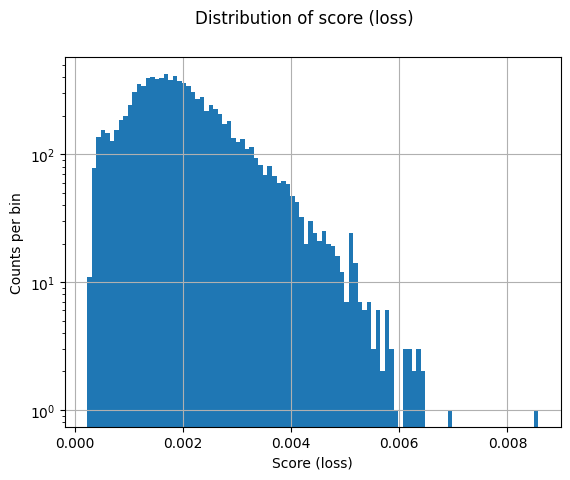

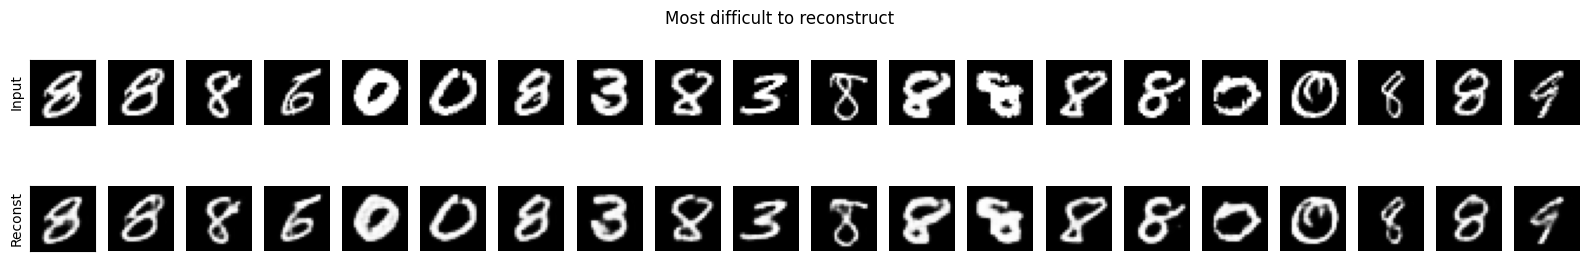

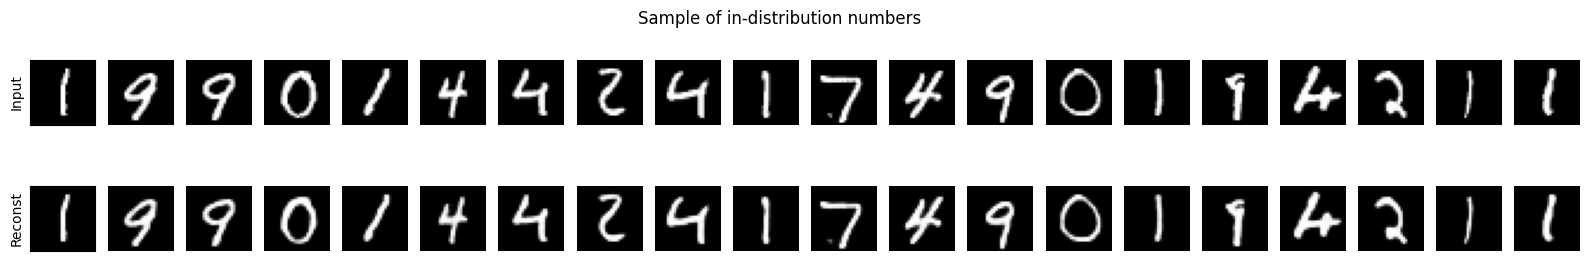

In [13]:
anomaly_detection_display(df)